# PART II - Data Preprocessing for Parkinson's Disease Detection

In the second part, we will perform data preprocessing to treat outliers, impute missing values, remove duplicate entries, Gaussian transformation for a non-normal distribution, balance the imbalanced data, feature scaling (standardization and normalization), feature binning (converting continuous data to categorical values), feature encoding (converting categorical data to continuous values), and so on.  There are lots of tasks to consider for preprocessing, and this is the most important and time-consuming task of all the stages in machine learning. Please refer the [Part 1 -EDA FOR PARKINSON'S DISEASE DETECTION ](https://github.com/MLewis231088/Parkinsons-Disease/blob/main/Part1_Parkinson'sDiseaseDetection_EDA.ipynb) to understand the data preprocessing steps better.

In this section, we will perform the following steps:
- Handling missing values
- Resampling imbalanced data
- Handling outliers
- Transforming Data (Gaussian Transformation for a non-normal distribution)
- Feature Scaling (standardization and normalization)
- Feature Binning (Continuous to Categorical)
- Feature Encoding (Categorical to Continuous)

To begin with, we'll import the necessary libraries and load the dataset.

### **Loading the libraries**

In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
import scipy.stats as stats
import pylab

# to remove future warnings with seaborn
import warnings
warnings.filterwarnings("ignore")

### **Importing the dataset**

In [ ]:
data = pd.read_csv('Parkinsons.csv')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### **Visualizing Missing Values**


Let's try to find out if there are any missing values in the dataset. 

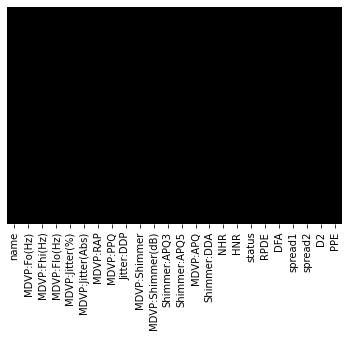

In [ ]:
sns.heatmap(data.isna(),yticklabels=False,cbar=False,cmap='bone');

There are no missing values in the dataset.

### **Handling Outliers**

We'll handle outliers based on the type of distribution of features. Since this dataset is very small with only 195 entries, we'll not remove the outliers. There are many ways to treat outliers. In this section, we will use the Inter Quartile Range (IQR). The IQR describes the middle 50% of values when ordered from lowest to highest i.e., it measure the region where majority of data points lie.

    IQR = Q3 – Q1 = 75th percentile - 25th percentile

- If the features are normally distributed, we'll set the data points which exceeds 1.5 * IQR, with the upper and lower fence values respectively. 
	  For example, if Q3 is 10 and Q1 is 2, IQR is 8, then 1.5*IQR is 12.
	  upper fence value = Q3 + 1.5*IQR  =  10 + 12 = 22
       lower fence value = Q1 - 1.5*IQR  =  2 - 12 = -10
- For skewed distribution, we'll set those data points which exceeds 3* IQR, with the upper and lower fence values respectively. 
	  For example, if Q3 is 10 and Q1 is 2, IQR is 8, then 3*IQR is 24.
	  upper fence value = Q3 + 3*IQR  =  10 + 24 = 34
       lower fence value = Q1 - 3*IQR  =  2 - 24 = -22


In the next step, we will use the Shapiro-Wilko method to check if the distribution is Gaussian (Normal Distribution) or not. From EDA in PART I, we already know that most of the features are highly skewed. Let's confirm it using the Shapiro-Wilko method. 

### **Checking for Normality distribution using Shapiro-Wilko method**

In [ ]:
def get_Normality_Check(data):
    '''
    This function uses Shapiro-Wilko method to test Normality at an alpha of 0.05.
    Ho: The sample  data is Normally distributed.
    H1: The sample data is not Normally distributed.
    Usage:
        1) df : Data Frame with all features who's normality needs to be tested.
    Returns:
        1) DataFrame with Features, Normality (Yes/No) and corresponding P_value as columns.
    '''
    alpha = 0.05
    normal,p_value,cols=[],[],[]
    for i in data.columns:
        if (data[i].dtype.name == 'int64' or data[i].dtype.name == 'float64'):
            df = data[i]
            if shapiro(df)[1] > alpha :
                normal.append('Yes')
            else:
                normal.append('No')
            p_value.append(round(shapiro(df)[1],8))
            cols.append(i)
        else:
            pass
    normality_df = pd.DataFrame({'Features':cols,'Normality':normal,'P-Value':p_value})
    normality_df.set_index('Features',inplace=True)
    return(normality_df)


In [ ]:
get_Normality_Check(data)

,Normality,P-Value
Features,,
MDVP:Fo(Hz),No,1.700000e-07
MDVP:Fhi(Hz),No,0.000000e+00
MDVP:Flo(Hz),No,0.000000e+00
MDVP:Jitter(%),No,0.000000e+00
MDVP:Jitter(Abs),No,0.000000e+00
MDVP:RAP,No,0.000000e+00
MDVP:PPQ,No,0.000000e+00
Jitter:DDP,No,0.000000e+00
MDVP:Shimmer,No,0.000000e+00


As none of the features are normally distributed, we'll set those data points which exceeds 3* IQR, with the upper and lower fence values respectively. 
We have defined a function that caps the outliers with upper and lower fence values, and then displays the upper and lower fence values of all the features.

In [ ]:
def outlier(data):
    df = pd.DataFrame(columns=['Feature','Lower fence','Upper fence'])
    for i in data.columns:
        if i!= 'status':
            if (data[i].dtype.name == 'int64' or data[i].dtype.name == 'float64'):
                Q1,Q3 = np.percentile(data[i],[25,75])
                IQR = Q3 - Q1
                LB = Q1 - 3 * IQR
                UB = Q3 + 3 * IQR
                df = df.append({'Feature' : i, 
                                    'Lower fence': LB, 
                                    'Upper fence': UB},
                                     ignore_index=True)
                data.loc[data[i]>=UB,i]=UB
                data.loc[data[i]<=LB,i]=LB
                data.to_csv('ParkinsonCleanData.csv')
    return df
    

            
outlier(data)

,Feature,Lower fence,Upper fence
0,MDVP:Fo(Hz),-78.019000,378.360000
1,MDVP:Fhi(Hz),-133.166500,492.234500
2,MDVP:Flo(Hz),-82.891500,307.201000
3,MDVP:Jitter(%),-0.008255,0.019080
4,MDVP:Jitter(Abs),-0.000100,0.000180
5,MDVP:RAP,-0.004865,0.010360
6,MDVP:PPQ,-0.004425,0.010240
7,Jitter:DDP,-0.014575,0.031065
8,MDVP:Shimmer,-0.047635,0.102025
9,MDVP:Shimmer(dB),-0.456000,0.954500


We have saved this dataframe as 'ParkinsonCleanData.csv'. We will be using this dataframe for the next step.

### **Feature Scaling**

As the machine learning algorithms work better in data which is normally distributed and when scaled to same range, we will normalize and standardize the data.

In [ ]:
clean_data = pd.read_csv('ParkinsonCleanData.csv',index_col=0)
data = clean_data.drop(['name'], axis=1)
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


#### ***Standardization and Normalization***

There are different methods for standardizing data. Some are as follows:
- Standard Scalar
- Min Max Scalar (Normalization)
- Robust Scalar
    
Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. It is not necessary to do both standardization and normalization techniques. Either of them will do. In this project, we have used both the techniques.

In [ ]:
# Standardization (Standard Scalar)
scaler=StandardScaler()

data_scaled=scaler.fit_transform(data)
std_scale=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
std_scale.to_csv('ParkinsonCleanStandardizedData.csv')
std_scale.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,-0.829300,-0.456604,-0.952037,0.484423,0.844002,0.260886,1.048042,0.259475,0.766112,0.787502,...,0.607791,0.065866,-0.193225,0.571429,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886
1,-0.770972,-0.562017,-0.057721,0.965561,1.160625,0.694720,1.712578,0.693503,1.721152,1.867334,...,1.548797,-0.059882,-0.634508,0.571429,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605
2,-0.909476,-0.775707,-0.109875,1.179981,1.477247,1.055488,2.110364,1.057477,1.232237,1.089855,...,1.175753,-0.336349,-0.279760,0.571429,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661
3,-0.909622,-0.693345,-0.114229,1.041392,1.477247,0.863687,1.721938,0.862545,1.372780,1.278825,...,1.340709,-0.316729,-0.281346,0.571429,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954
4,-0.925657,-0.645707,-0.130608,1.791863,2.110493,1.562389,2.704703,1.564604,1.879059,1.640569,...,1.900111,-0.132120,-0.506745,0.571429,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082


Let's visualize how the standardized data looks like.

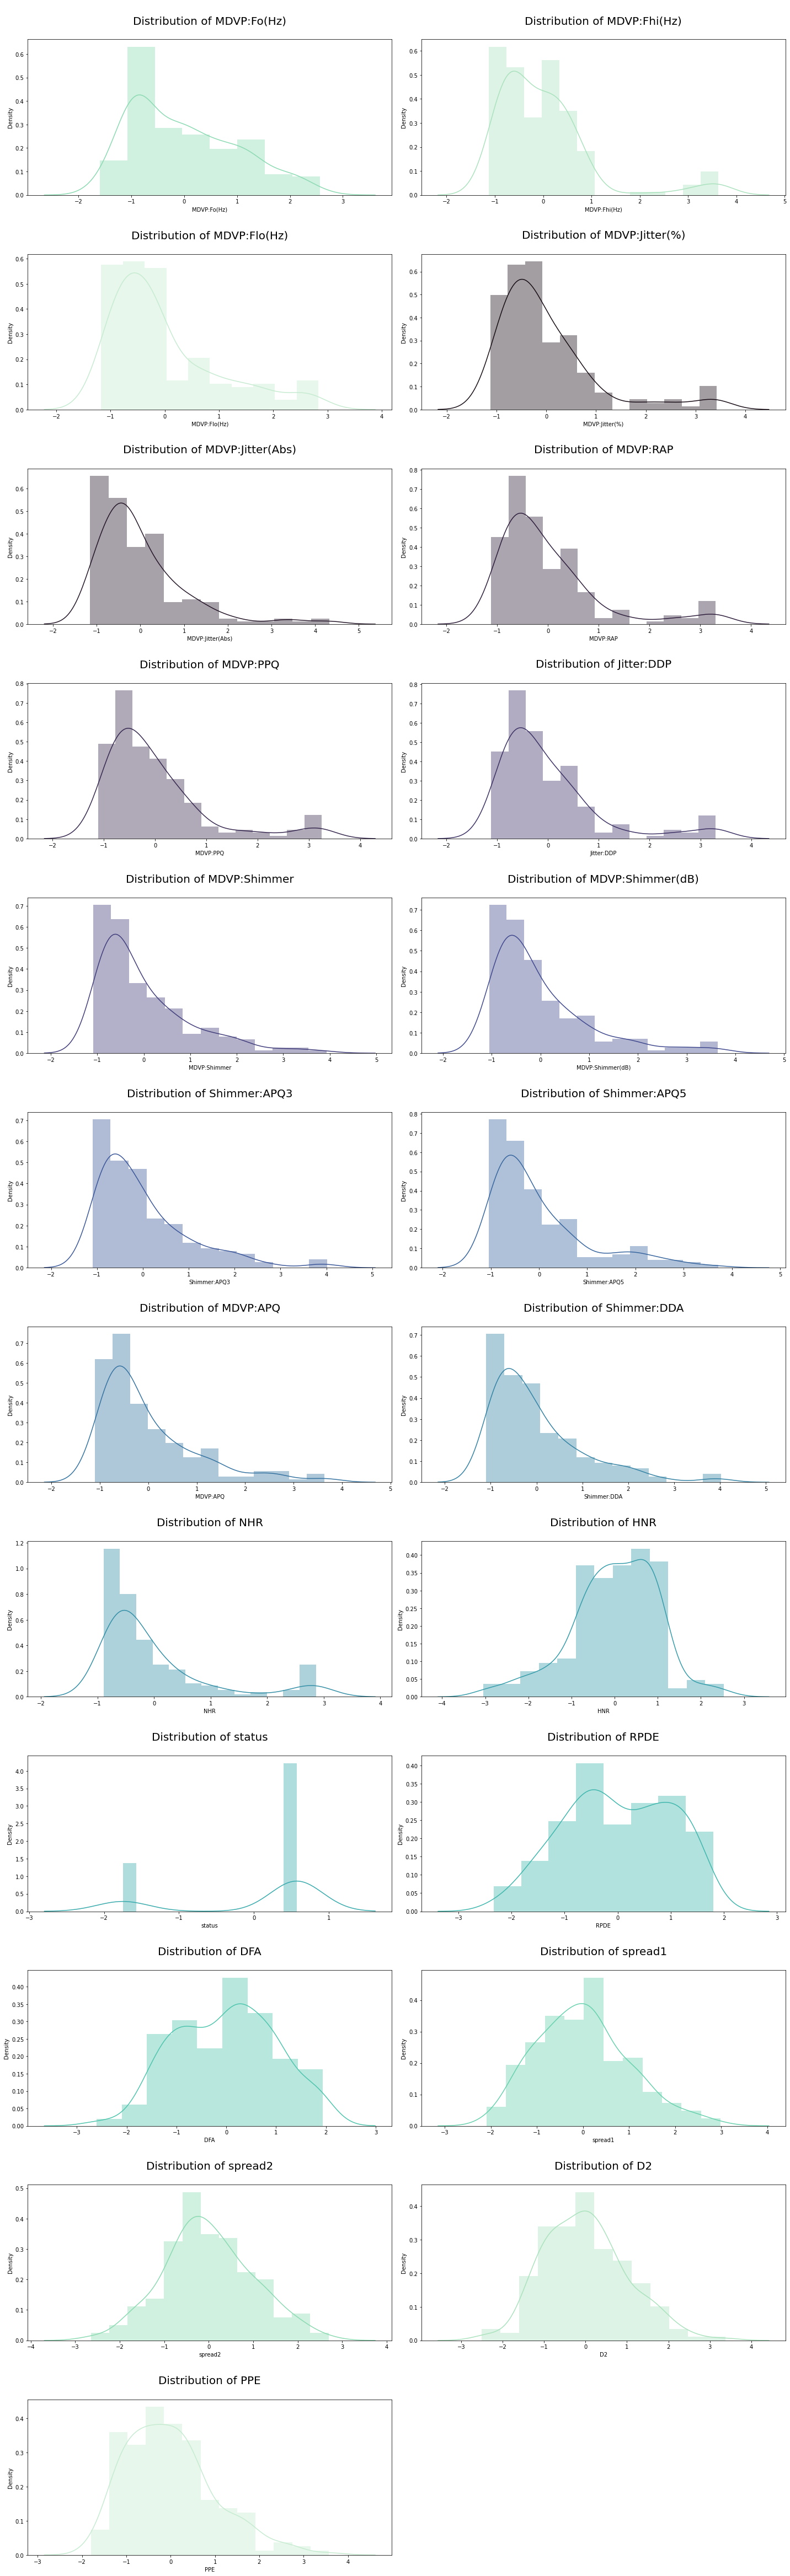

In [ ]:
color = sns.color_palette("mako", 20)
fig, ax = plt.subplots(figsize = (20, 65))
for n, col in enumerate(std_scale.columns):
    try:
        if (std_scale[col].dtype.name == 'int64' or std_scale[col].dtype.name == 'float64'): 
            plt.subplot(12, 2, n+1)
            sns.distplot(std_scale[col], kde = True, color=color[n-3])
            plt.title(f"\nDistribution of {col}\n",fontdict=dict(fontsize=20))
            plt.tight_layout();
        else:
            print(f"\n Histogram is unavailable for categorical variable '{col}'")
            pass 
    
    except IndexError:
        pass

In reality, we cannot make the skewed distribution perfectly normal. This will hamper the existing distribution and the models will not perform well. Now, let's perform min-max scaling to see if it brings any difference to the distribution.

In [ ]:
# Normalization (Min Max Scalar)
data = pd.read_csv('ParkinsonCleanStandardizedData.csv', index_col=0)

min_max=MinMaxScaler()
minmax=pd.DataFrame(min_max.fit_transform(data),columns=data.columns)
minmax.to_csv('ParkinsonCleanStandardizedNormalizedData.csv')
minmax.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,0.184308,0.141396,0.054815,0.354023,0.364162,0.311983,0.495708,0.311800,0.369790,0.392179,...,0.333537,0.255066,0.511745,1.0,0.369155,0.960148,0.569875,0.585765,0.390661,0.497310
1,0.198327,0.119216,0.278323,0.459770,0.421965,0.410124,0.648069,0.409991,0.560091,0.622197,...,0.517527,0.221549,0.432577,1.0,0.470830,0.977024,0.703277,0.741337,0.473145,0.671326
2,0.165039,0.074255,0.265288,0.506897,0.479769,0.491736,0.739270,0.492334,0.462670,0.456584,...,0.444588,0.147858,0.496220,1.0,0.404416,1.000000,0.636745,0.686371,0.408819,0.596682
3,0.165004,0.091584,0.264200,0.476437,0.479769,0.448347,0.650215,0.448234,0.490674,0.496837,...,0.476840,0.153087,0.495936,1.0,0.416255,0.975885,0.695627,0.738089,0.436977,0.671949
4,0.161150,0.101607,0.260107,0.641379,0.595376,0.606405,0.875536,0.607063,0.591555,0.573893,...,0.586217,0.202294,0.455499,1.0,0.375159,0.992813,0.762472,0.513798,0.404336,0.757611


Let's visualize how the min - max scaled data looks like.

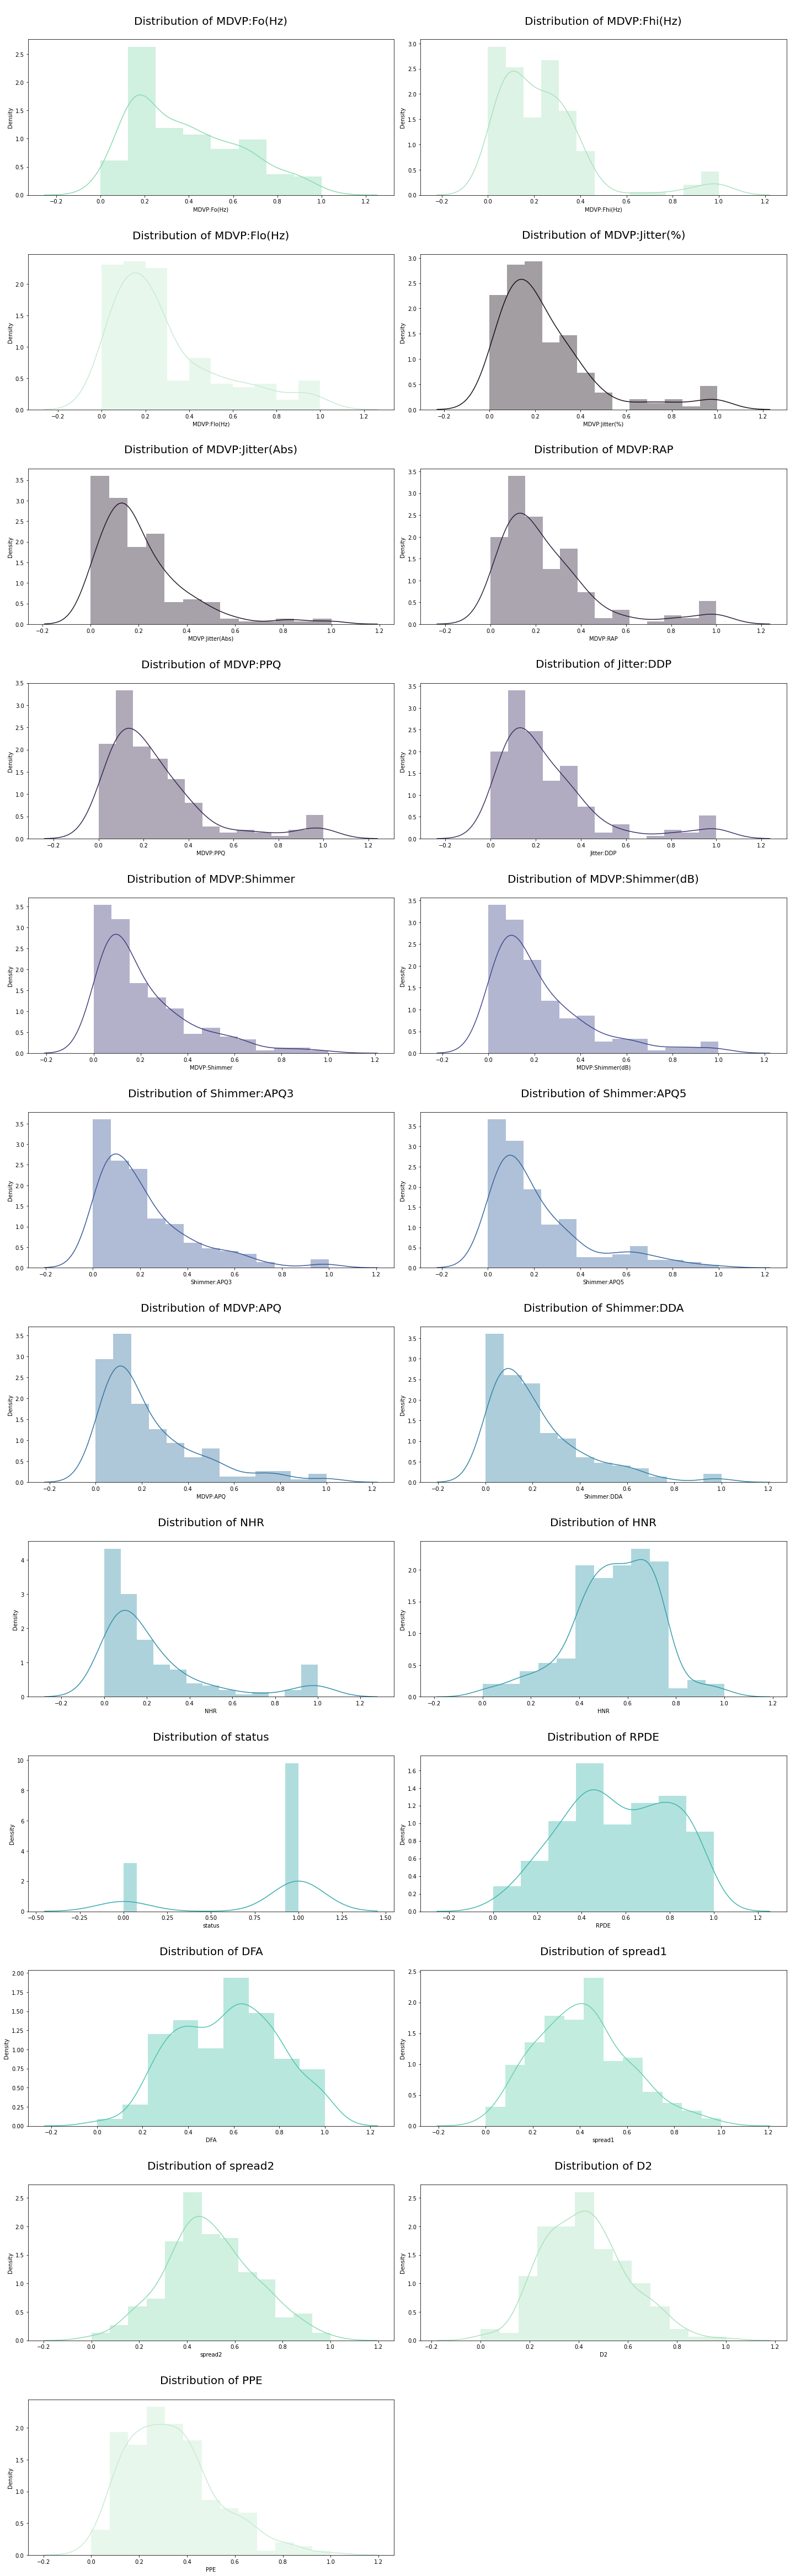

In [ ]:
color = sns.color_palette("mako", 20)
fig, ax = plt.subplots(figsize = (20, 65))
for n, col in enumerate(minmax.columns):
    try:
        if (minmax[col].dtype.name == 'int64' or minmax[col].dtype.name == 'float64'): 
            plt.subplot(12, 2, n+1)
            sns.distplot(minmax[col], kde = True, color=color[n-3])
            plt.title(f"\nDistribution of {col}\n",fontdict=dict(fontsize=20))
            plt.tight_layout();
        else:
            print(f"\n Histogram is unavailable for categorical variable '{col}'")
            pass 
    
    except IndexError:
        pass

There is not much difference in the distribution. In the next step, we will try using Gaussian Transformation techniques.

### **Gaussian Transformation**

From EDA, we could see that all the features except 'spread2' are skewed. The ML algorithms perform well for normal distributed data. There are various techniques to convert a non-normal distribution to a normal distribution. Following are some of the techniques:
- Log Transformation
- Reciprocal Transformation
- Square Root Transformation
- Exponential Transformation
- Box-Cox Transformation

In this project, we will use only Log Transformation and Box-Cox Transformation techniques. Before we proceed, let's use Q-Q plot to find out if the distribution is normal or not. In Statistics, Q-Q (quantile-quantile) plots play a very vital role to graphically analyze and compare two probability distributions by plotting their quantiles against each other. If the two distributions which we are comparing are exactly equal, then the points on the Q-Q plot will perfectly lie on a straight line.

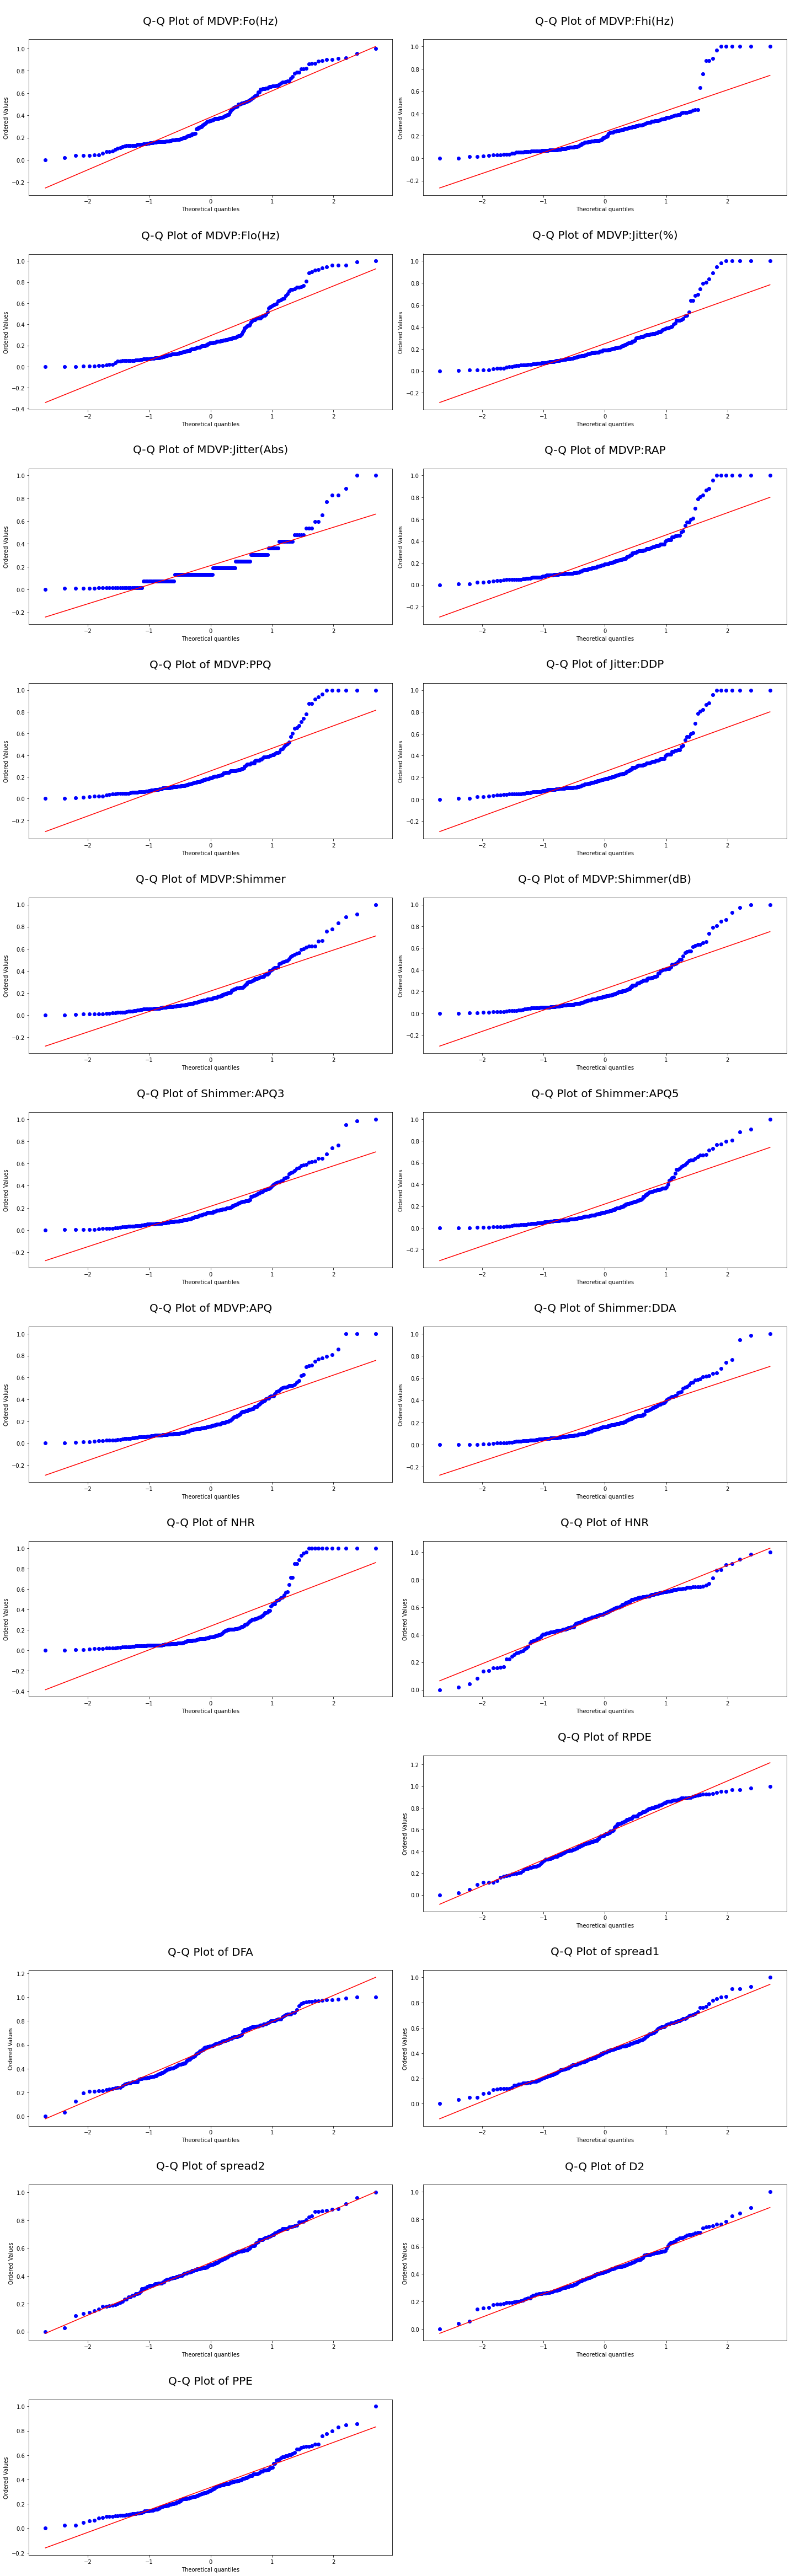

In [ ]:
# Visual Inspection using Q-Q Plots
data = pd.read_csv('ParkinsonCleanStandardizedNormalizedData.csv', index_col=0)

def plot_data(data):
    color = sns.color_palette("ocean", 20)
    fig, ax = plt.subplots(figsize = (20, 65))
    for n, col in enumerate(data.columns): 
        if col!= 'status':
            plt.subplot(12, 2, n+1)
            stat.probplot(data[col],dist='norm',plot=pylab)
            plt.title(f"\nQ-Q Plot of {col}\n",fontdict=dict(fontsize=20))
            plt.tight_layout();
    return plt.show();           
plot_data(data)

#### ***Log Transformation***

In Log transformation each variable of x will be replaced by log(x) with base 10, base 2, or natural log.

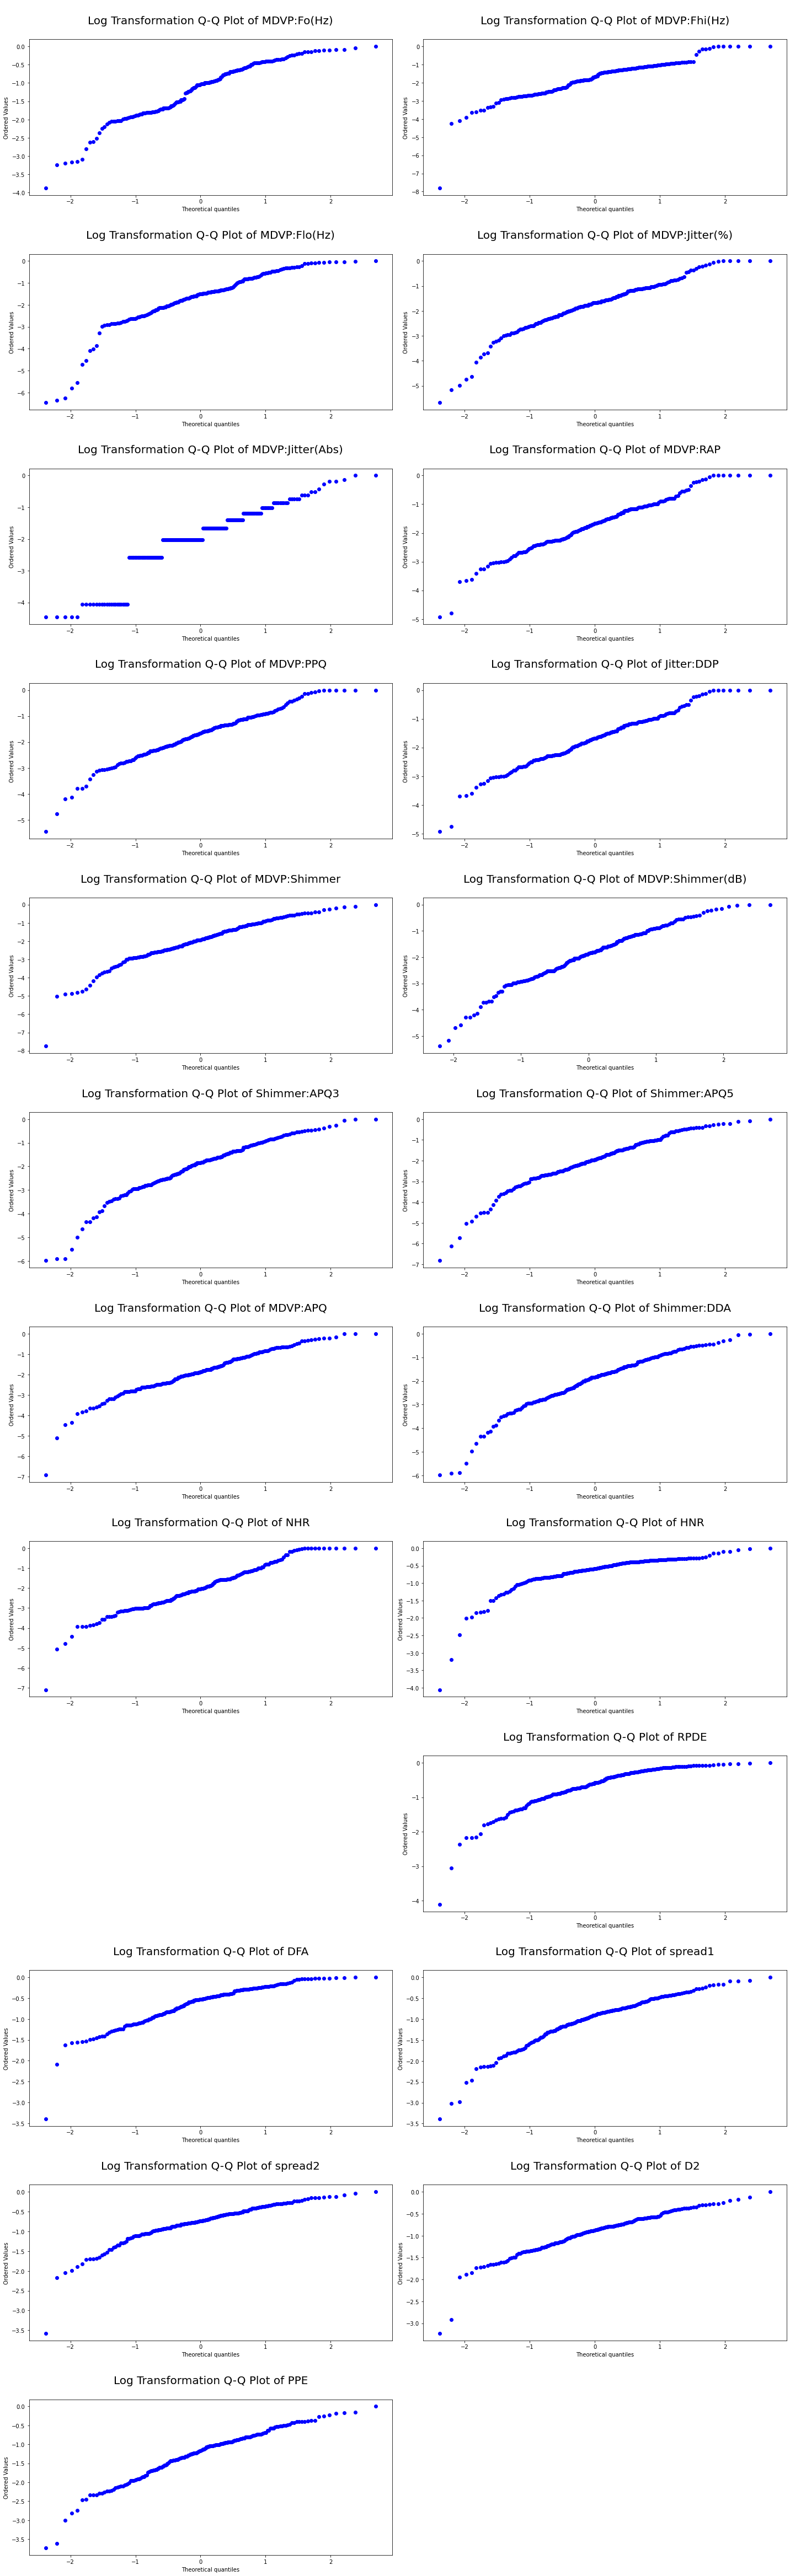

In [ ]:
data = pd.read_csv('ParkinsonCleanStandardizedNormalizedData.csv', index_col=0)

def log_plot(data):
    fig, ax = plt.subplots(figsize = (20, 65))
    for n, col in enumerate(data.columns): 
        if col!= 'status':
            plt.subplot(12, 2, n+1)
            data[col]=np.log(data[col])
            stat.probplot(data[col],dist='norm',plot=pylab)
            plt.title(f"\nLog Transformation Q-Q Plot of {col}\n",fontdict=dict(fontsize=20))
            plt.tight_layout();
            data.to_csv('ParkinsonFinalData.csv')
    return plt.show();           
log_plot(data)

From these plots, we can clearly see that the data points after log transformation are lying on a straight line to some extent. 

#### ***Checking the skewness***
Let's now quickly check the skewness of the dataset.

In [ ]:
df1 = pd.read_csv('ParkinsonFinalData.csv', index_col=0)
df2 = pd.read_csv('ParkinsonCleanData.csv', index_col=0)
df1.skew(axis = 0, skipna = True) 

MDVP:Fo(Hz)              NaN
MDVP:Fhi(Hz)             NaN
MDVP:Flo(Hz)             NaN
MDVP:Jitter(%)           NaN
MDVP:Jitter(Abs)         NaN
MDVP:RAP                 NaN
MDVP:PPQ                 NaN
Jitter:DDP               NaN
MDVP:Shimmer             NaN
MDVP:Shimmer(dB)         NaN
Shimmer:APQ3             NaN
Shimmer:APQ5             NaN
MDVP:APQ                 NaN
Shimmer:DDA              NaN
NHR                      NaN
HNR                      NaN
status             -1.187727
RPDE                     NaN
DFA                      NaN
spread1                  NaN
spread2                  NaN
D2                       NaN
PPE                      NaN
dtype: float64

None of the features are now skewed. So it means that the data is normally distributed. Let's confirm the same by performing another statistic test for normality - Chi-square test.

#### ***Chi-square test for normality***

In [ ]:
k2, p = stat.normaltest(df1)
print(f"\nChi-squared statistic: {k2}, {p}")

alpha = 0.05
if p.any() > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')


Chi-squared statistic: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan 37.81176728         nan
         nan         nan         nan         nan         nan], [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
 6.15572288e-09            nan            nan            nan
            nan            nan            nan]

The transformed data is Gaussian (fails to reject the null hypothesis)


The transformed data is Gaussian and fails to reject the null hypothesis. Now let's perform Box-Cox transformation method before we finalize.

#### ***Box-Cox Transformation***

The Box-Cox transformation is defined as:

    T(Y)=(Y exp(λ)−1)/λ

where Y is the response variable and λ is the transformation parameter. λ varies from -5 to 5. In the transformation, all values of λ are considered and the optimal value for a given variable is selected.

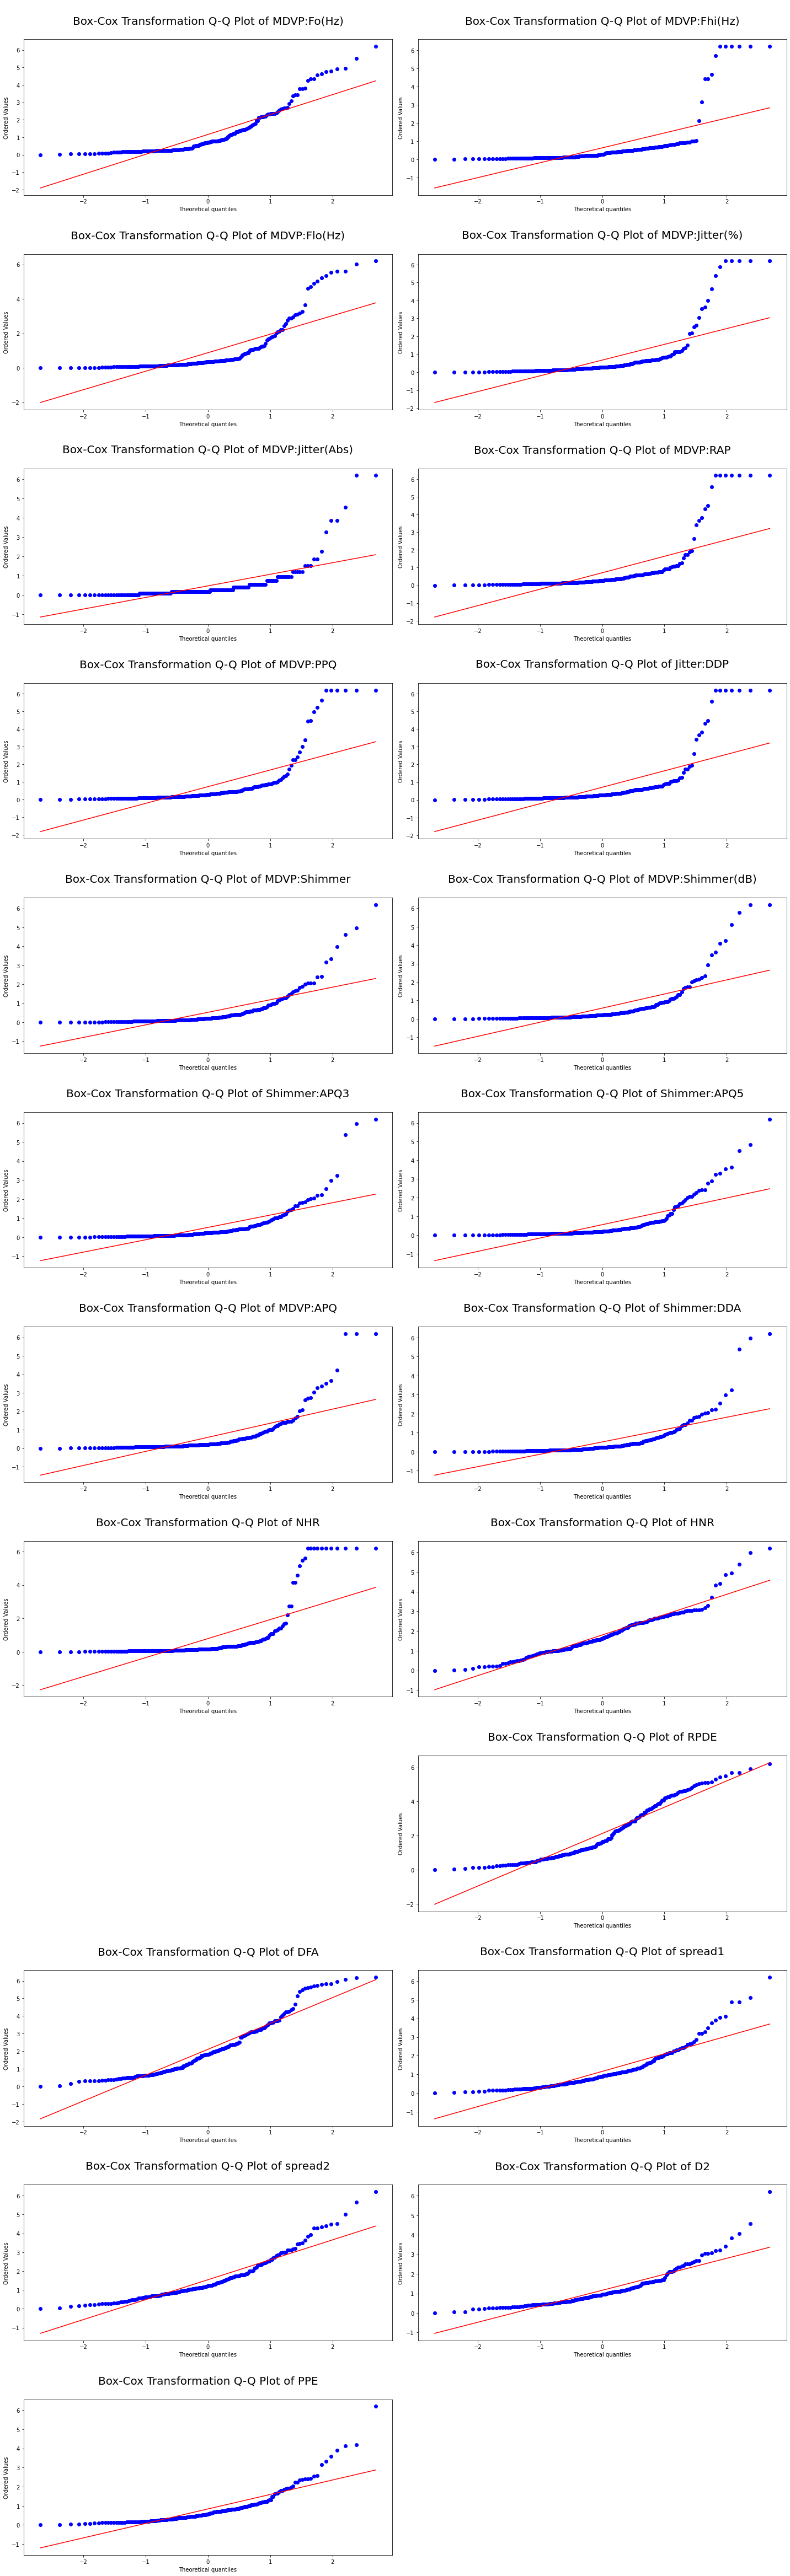

In [ ]:
import scipy
from scipy.special import boxcox1p

data = pd.read_csv('ParkinsonCleanStandardizedNormalizedData.csv', index_col=0)
def boxcox_plot(data):
    fig, ax = plt.subplots(figsize = (20, 65))
    for n, col in enumerate(data.columns): 
        if col!= 'status':
            plt.subplot(12, 2, n+1)
            data[col]=scipy.special.boxcox1p(data[col],5)
            stat.probplot(data[col],dist='norm',plot=pylab)
            plt.title(f"\nBox-Cox Transformation Q-Q Plot of {col}\n",fontdict=dict(fontsize=20))
            plt.tight_layout();
    return plt.show();           
boxcox_plot(data)

As log transformation works better than box-cox for this dataset, we will use the log transformation technique to convert the data to normally distributed one.

### **Feature Binning or Discretization**

Binning or discretization is used for the transformation of a continuous or numerical variable into a categorical feature. Binning of continuous variable introduces non-linearity and tends to improve the performance of the model. It can be also used to identify missing values or outliers.
There are two types of binning:
- Unsupervised Binning: 
        - Equal width binning
        - Equal frequency binning
- Supervised Binning: 
        - Entropy-based binning

In [ ]:
df = pd.read_csv('ParkinsonFinalData.csv', index_col=0)

def bin(data):
    df = pd.DataFrame(columns=['Feature','Unique Values','# of Unique Values'])
    for i in data.columns:
        if i!= 'status':
            if (data[i].dtype.name == 'int64' or data[i].dtype.name == 'float64'):
                data[i] = pd.qcut(data[i], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.], duplicates='drop')
                df = df.append({'Feature' : i, 
                                'Unique Values': data[i].unique(),
                                '# of Unique Values': len(data[i].unique())},
                                     ignore_index=True)
    return df.head(23)
    

            
bin(df)

,Feature,Unique Values,# of Unique Values
0,MDVP:Fo(Hz),"[(-1.814, -1.683], (-1.683, -1.436], (-2.038, ...",10
1,MDVP:Fhi(Hz),"[(-2.315, -1.907], (-2.826, -2.599], (-2.599, ...",10
2,MDVP:Flo(Hz),"[(-inf, -2.841], (-1.371, -1.134], (-1.751, -1...",10
3,MDVP:Jitter(%),"[(-1.067, -0.752], (-0.752, 0.0], (-2.467, -2....",10
4,MDVP:Jitter(Abs),"[(-1.183, -0.863], (-0.863, 0.0], (-2.588, -2....",8
5,MDVP:RAP,"[(-1.19, -1.033], (-1.033, -0.718], (-0.718, 0...",10
6,MDVP:PPQ,"[(-1.004, -0.665], (-0.665, 0.0], (-2.172, -1....",10
7,Jitter:DDP,"[(-1.19, -1.034], (-1.034, -0.718], (-0.718, 0...",10
8,MDVP:Shimmer,"[(-1.063, -0.69], (-0.69, 0.0], (-2.805, -2.47...",10
9,MDVP:Shimmer(dB),"[(-1.076, -0.666], (-0.666, 0.0], (-2.817, -2....",10


We have discretized the feature values into 10 different bins ranging between 0th percentile and 100th percentile.

### **Feature Encoding**

Feature Encoding is used for the transformation of a categorical feature into a numerical variable. Most of the ML algorithms cannot handle categorical variables and hence it is important to do feature encoding. There are many encoding techniques used for feature engineering:
- Label Encoding
- Ordinal Encoding
- Frequency Encoding
- Binary Encoding
- One-Hot Encoding
- Target Mean Encoding

As all the features in the dataset are continuous variables, we'll not perform feature encoding.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#4863A0"> Feature Importance and Feature Selection

In [ ]:
df = pd.read_csv('ParkinsonCleanStandardizedNormalizedData.csv',index_col=0)
df = df.drop(['status'], axis=1)

def get_VIF_Table(df):
    '''
    Function to get the Variance Inflation Factor from the data frame:
    Usage: get_VIF_Table(pd.DataFrame)
    (1) df : Dataframe
    
    Return:
        Returns the Table containing the list of column names or features and VIF for each of them.
    '''
    X = df
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 
    vif_data["VIF"] =[variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    return vif_data

In [ ]:
get_VIF_Table(df)

,feature,VIF
0,MDVP:Fo(Hz),2.022898e+01
1,MDVP:Fhi(Hz),3.953918e+00
2,MDVP:Flo(Hz),5.196452e+00
3,MDVP:Jitter(%),2.713628e+02
4,MDVP:Jitter(Abs),7.200367e+01
5,MDVP:RAP,1.753722e+06
6,MDVP:PPQ,1.707663e+02
7,Jitter:DDP,1.754024e+06
8,MDVP:Shimmer,1.655740e+03
9,MDVP:Shimmer(dB),1.718165e+02


Feature selection can be done in multiple ways but they are broadly classified as:
1. Filter Methods
2. Wrapper Methods
3. Embedded Methods
4. Hybrid Methods

<span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#4E9258`m"> Filter Methods

Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. These methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods.

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Information Gain

In [ ]:
df = pd.read_csv('ParkinsonCleanData.csv',index_col=0)
X = df.drop(['status','name'], axis=1)   #Feature Matrix
y = df["status"]          #Target Variable

In [ ]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, df.columns[1:len(df.columns)-1])
feat_importances.plot(kind='barh', color = 'teal')
plt.show();

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Pearson Correlation

In [ ]:
# Pearson Correlation

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,22)
print(str(len(cor_feature)), 'selected features')

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Chi-Square

In [ ]:
# Chi-squared

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

num_feats = 22

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')


<span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#4E9258`m"> Wrapper Methods

Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Recursive Feature Elimination

In [ ]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

num_feats = 22

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

<span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#4E9258`m"> Embedded Methods

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
Here, we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Lasso Regularization

In [ ]:
# Lasso

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#914D87"> Tree Based

In [ ]:
# Tree based

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

In [ ]:
data = pd.read_csv('ParkinsonFinalData.csv', index_col=0)
data = data[['MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'MDVP:APQ', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']]
data.to_csv('ParkinsonFinalSelectedFeaturesData.csv')

As all the features in the dataset are continuous variables, we'll not perform feature encoding.

We have now completed the data preprocessing of Parkinson's dataset. We have considered the following techniques:
Capped the outliers to upper and lower fence values
Standardized and normalized the data
Used Log Transformation to convert the data into Gaussian
In the next part, we will see how to build various machine learning models using PyCaret library to predict Parkinson's disease in patients.